# Mini Project 1 - SVM & LR Classification -- 2013/2014 CitiBike-NYC Data
**Michael Smith, Alex Frye, Chris Boomhower ----- 2/08/2017**

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2/Images/Citi-Bike.jpg?raw=true" width="400">

<center>Image courtesy of http://newyorkeronthetown.com/, 2017</center>

### Introduction
*** Describe the purpose of the model you are about to build ***

The data set again selected by our group for the mini-lab consists of [Citi Bike trip history](https://www.citibikenyc.com/system-data) data collected and released by NYC Bike Share, LLC and Jersey Bike Share, LLC under Citi Bike's [NYCBS Data Use Policy](https://www.citibikenyc.com/data-sharing-policy). Citi Bike is America's largest bike share program, with 10,000 bikes and 600 stations across Manhattan, Brooklyn, Queens, and Jersey City... 55 neighborhoods in all. As such, our data set's trip history includes all rental transactions conducted within the NYC Citi Bike system from July 1st, 2013 to February 28th, 2014. These transactions amount to 5,562,293 trips within this time frame. The original data set includes 15 attributes. In addition to these 15, our team was able to derive 15 more attributes for use in our classification efforts, some attributes of which are NYC weather data which come from [Carbon Dioxide Information Analysis Center (CDIAC)](http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_daily.sas&_SERVICE=default&id=305801&_DEBUG=0). These data are merged with the Citi Bike data to provide environmental insights into rider behavior.

The trip data was collected via Citi Bike's check-in/check-out system among 330 of its stations in the NYC system as part of its transaction history log. While the non-publicized data likely includes further particulars such as rider payment details, the publicized data is anonymized to protect rider identity while simultaneously offering bike share transportation insights to urban developers, engineers, academics, statisticians, and other interested parties. The CDIAC data, however, was collected by the Department of Energy's Oak Ridge National Laboratory for research into global climate change. While basic weather conditions are recorded by CDIAC, as included in our fully merged data set, the organization also measures atmospheric carbon dioxide and other radiatively active gas levels to conduct their research efforts.

Our team has taken particular interest in this data set as some of our team members enjoy both recreational and commute cycling. By combining basic weather data with Citi Bike's trip data, **our intent in this mini-lab is to predict whether riders are more likely to be (or become) Citi Bike subscribers based on ride environmental conditions, the day of the week for his/her trip, trip start and end locations, the general time of day (i.e. morning, midday, afternoon, evening, night) of his/her trip, his/her age and gender, etc.** Due to the exhaustive number of observations in the original data set (5,562,293), a sample of 500,000 is selected to achieve this goal (as described further in the sections below). By leveraging 80% of the samples as training data and 20% as test data via randomized selection, we expect to be able to derive a dependable and accurate user type prediction model for which accuracy and performance will be discussed in detail.

### Load the Data

##### Compiling Multiple Data Sources
To begin our analysis, we need to load the data from our source .csv files. Steps taken to pull data from the various source files are as follows:
- For each file from CitiBike, we process each line appending manually computed columns [LinearDistance, DayOfWeek, TimeOfDay, & HolidayFlag]. 
- Similarly, we load our weather data .csv file.
- With both source file variables gathered, we append the weather data to our CitiBike data by matching on the date.
- To avoid a 2 hour run-time in our analysis every execution, we load the final version of the data into .CSV files. Each file consists of 250000 records to reduce file size for GitHub loads.
- All above logic is skipped if the file "Compiled Data/dataset1.csv" already exists.

Below you will see this process, as well as import/options for needed python modules throughout this analysis.

In [1]:
import os
from geopy.distance import vincenty
import holidays
from datetime import datetime
from dateutil.parser import parse
import glob
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import cross_val_score

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
############################################################
# Load & Merge Data from Source Files
# Parse into Compiled Files
############################################################

starttime = datetime.now()
print('Starting Source Data Load & Merge Process. \n'
      'Start Time: ' + str(starttime))

if os.path.isfile("Compiled Data/dataset1.csv"):
    print("Found the File!")
else:
    citiBikeDataDirectory = "Citi Bike Data"
    citiBikeDataFileNames = [
        "2013-07 - Citi Bike trip data - 1.csv",
        "2013-07 - Citi Bike trip data - 2.csv",
        "2013-08 - Citi Bike trip data - 1.csv",
        "2013-08 - Citi Bike trip data - 2.csv",
        "2013-09 - Citi Bike trip data - 1.csv",
        "2013-09 - Citi Bike trip data - 2.csv",
        "2013-10 - Citi Bike trip data - 1.csv",
        "2013-10 - Citi Bike trip data - 2.csv",
        "2013-11 - Citi Bike trip data - 1.csv",
        "2013-11 - Citi Bike trip data - 2.csv",
        "2013-12 - Citi Bike trip data.csv",
        "2014-01 - Citi Bike trip data.csv",
        "2014-02 - Citi Bike trip data.csv"
    ]

    weatherDataFile = "Weather Data/NY305801_9255_edited.txt"

    citiBikeDataRaw = []

    for file in citiBikeDataFileNames:
        print(file)
        filepath = citiBikeDataDirectory + "/" + file
        with open(filepath) as f:
            lines = f.read().splitlines()
            lines.pop(0)  # get rid of the first line that contains the column names
            for line in lines:
                line = line.replace('"', '')
                line = line.split(",")
                sLatLong = (line[5], line[6])
                eLatLong = (line[9], line[10])

                distance = vincenty(sLatLong, eLatLong).miles
                line.extend([distance])

                ## Monday       = 0
                ## Tuesday      = 1
                ## Wednesday    = 2
                ## Thursday     = 3
                ## Friday       = 4
                ## Saturday     = 5
                ## Sunday       = 6
                if parse(line[1]).weekday() == 0:
                    DayOfWeek = "Monday"
                elif parse(line[1]).weekday() == 1:
                    DayOfWeek = "Tuesday"
                elif parse(line[1]).weekday() == 2:
                    DayOfWeek = "Wednesday"
                elif parse(line[1]).weekday() == 3:
                    DayOfWeek = "Thursday"
                elif parse(line[1]).weekday() == 4:
                    DayOfWeek = "Friday"
                elif parse(line[1]).weekday() == 5:
                    DayOfWeek = "Saturday"
                else:
                    DayOfWeek = "Sunday"
                line.extend([DayOfWeek])

                ##Morning       5AM-10AM
                ##Midday        10AM-2PM
                ##Afternoon     2PM-5PM
                ##Evening       5PM-10PM
                ##Night         10PM-5AM

                if parse(line[1]).hour >= 5 and parse(line[1]).hour < 10:
                    TimeOfDay = 'Morning'
                elif parse(line[1]).hour >= 10 and parse(line[1]).hour < 14:
                    TimeOfDay = 'Midday'
                elif parse(line[1]).hour >= 14 and parse(line[1]).hour < 17:
                    TimeOfDay = 'Afternoon'
                elif parse(line[1]).hour >= 17 and parse(line[1]).hour < 22:
                    TimeOfDay = 'Evening'
                else:
                    TimeOfDay = 'Night'
                line.extend([TimeOfDay])

                ## 1 = Yes
                ## 0 = No
                if parse(line[1]) in holidays.UnitedStates():
                    holidayFlag = "1"
                else:
                    holidayFlag = "0"
                line.extend([holidayFlag])

                citiBikeDataRaw.append(line)
            del lines

    with open(weatherDataFile) as f:
        weatherDataRaw = f.read().splitlines()
        weatherDataRaw.pop(0)  # again, get rid of the column names
        for c in range(len(weatherDataRaw)):
            weatherDataRaw[c] = weatherDataRaw[c].split(",")
            # Adjust days and months to have a leading zero so we can capture all the data
            if len(weatherDataRaw[c][2]) < 2:
                weatherDataRaw[c][2] = "0" + weatherDataRaw[c][2]
            if len(weatherDataRaw[c][0]) < 2:
                weatherDataRaw[c][0] = "0" + weatherDataRaw[c][0]

    citiBikeData = []

    while (citiBikeDataRaw):
        instance = citiBikeDataRaw.pop()
        date = instance[1].split(" ")[0].split("-")  # uses the start date of the loan
        for record in weatherDataRaw:
            if (str(date[0]) == str(record[4]) and str(date[1]) == str(record[2]) and str(date[2]) == str(record[0])):
                instance.extend([record[5], record[6], record[7], record[8], record[9]])
                citiBikeData.append(instance)

    del citiBikeDataRaw
    del weatherDataRaw

    # Final Columns:
    #  0 tripduration
    #  1 starttime
    #  2 stoptime
    #  3 start station id
    #  4 start station name
    #  5 start station latitude
    #  6 start station longitude
    #  7 end station id
    #  8 end station name
    #  9 end station latitude
    # 10 end station longitude
    # 11 bikeid
    # 12 usertype
    # 13 birth year
    # 14 gender
    # 15 start/end station distance
    # 16 DayOfWeek
    # 17 TimeOfDay
    # 18 HolidayFlag
    # 19 PRCP
    # 20 SNOW
    # 21 TAVE
    # 22 TMAX
    # 23 TMIN

    maxLineCount = 250000
    lineCounter = 1
    fileCounter = 1
    outputDirectoryFilename = "Compiled Data/dataset"
    f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
    for line in citiBikeData:
        if lineCounter == 250000:
            print(f)
            f.close()
            lineCounter = 1
            fileCounter = fileCounter + 1
            f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
        f.write(",".join(map(str, line)) + "\n")
        lineCounter = lineCounter + 1

    del citiBikeData

endtime = datetime.now()
print('Ending Source Data Load & Merge Process. \n'
      'End Time: ' + str(starttime) + '\n'
                                      'Total RunTime: ' + str(endtime - starttime))

Starting Source Data Load & Merge Process. 
Start Time: 2017-02-19 23:49:30.729897
Found the File!
Ending Source Data Load & Merge Process. 
End Time: 2017-02-19 23:49:30.729897
Total RunTime: 0:00:00.001501


##### Loading the Compiled Data from CSV

Now that we have compiled data files from both CitiBike and the weather data, we want to load that data into a Pandas dataframe for analysis. We iterate and load each file produced above, then assign each column with their appropriate data types. Additionally, we compute the Age Column after producing a default value for missing "Birth Year" values. This is discussed further in the Data Quality section.

In [3]:
%%time
############################################################
# Load the Compiled Data from CSV
############################################################

# Create CSV Reader Function and assign column headers
def reader(f, columns):
    d = pd.read_csv(f)
    d.columns = columns
    return d


# Identify All CSV FileNames needing to be loaded
path = r'Compiled Data'
all_files = glob.glob(os.path.join(path, "*.csv"))

# Define File Columns
columns = ["tripduration", "starttime", "stoptime", "start_station_id", "start_station_name",
           "start_station_latitude",
           "start_station_longitude", "end_station_id", "end_station_name", "end_station_latitude",
           "end_station_longitude", "bikeid", "usertype", "birth year", "gender", "LinearDistance", "DayOfWeek",
           "TimeOfDay", "HolidayFlag", "PRCP", "SNOW", "TAVE", "TMAX", "TMIN"]

# Load Data
CitiBikeDataCompiled = pd.concat([reader(f, columns) for f in all_files])

# Replace '\N' Birth Years with Zero Values
CitiBikeDataCompiled["birth year"] = CitiBikeDataCompiled["birth year"].replace(r'\N', '0')

# Convert Columns to Numerical Values
CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX', 'TMIN']] \
    = CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX',
                            'TMIN']].apply(pd.to_numeric)

# Convert Columns to Date Values
CitiBikeDataCompiled[['starttime', 'stoptime']] \
    = CitiBikeDataCompiled[['starttime', 'stoptime']].apply(pd.to_datetime)

# Compute Age: 0 Birth Year = 0 Age ELSE Compute Start Time Year Minus Birth Year
CitiBikeDataCompiled["Age"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 0,
                                       CitiBikeDataCompiled["starttime"].dt.year - CitiBikeDataCompiled[
                                           "birth year"])

# Convert Columns to Str Values
CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']] \
    = CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']].astype(str)

Wall time: 1min 57s


In [4]:
%%time
print(len(CitiBikeDataCompiled))
display(CitiBikeDataCompiled.head())

5562293


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age
0,308,2014-02-28 23:59:10,2014-03-01 00:04:18,353,S Portland Ave & Hanson Pl,40.685396,-73.974315,365,Fulton St & Grand Ave,40.682232,-73.961458,14761,Subscriber,1982,1,0.709731,Friday,Night,0,0.0,0.0,17,24,9,32
1,304,2014-02-28 23:58:17,2014-03-01 00:03:21,497,E 17 St & Broadway,40.737050,-73.990093,334,W 20 St & 7 Ave,40.742388,-73.997262,17112,Subscriber,1968,1,0.526555,Friday,Night,0,0.0,0.0,17,24,9,46
2,1355,2014-02-28 23:57:55,2014-03-01 00:20:30,470,W 20 St & 8 Ave,40.743453,-74.000040,302,Avenue D & E 3 St,40.720828,-73.977932,15608,Subscriber,1985,2,1.945255,Friday,Night,0,0.0,0.0,17,24,9,29
3,848,2014-02-28 23:57:13,2014-03-01 00:11:21,498,Broadway & W 32 St,40.748549,-73.988084,432,E 7 St & Avenue A,40.726218,-73.983799,17413,Subscriber,1976,1,1.557209,Friday,Night,0,0.0,0.0,17,24,9,38
4,175,2014-02-28 23:57:12,2014-03-01 00:00:07,383,Greenwich Ave & Charles St,40.735238,-74.000271,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,15220,Subscriber,1956,1,0.288829,Friday,Night,0,0.0,0.0,17,24,9,58


Wall time: 56.5 ms


### Data Quality

##### Measurable Data Quality Factors
When analyzing our final dataset for accurate measures, there are a few key factors we can easily verify/research:
- Computational Accuracy: Ensure data attributes added by computation are correct
    + TimeOfDay
    + DayOfWeek        
    + HolidayFlag
    
- Missing Data from Source
- Duplicate Data from Source
- Outlier Detection
- Sampling to 500,000 Records for further analysis

##### Immesurable Data Quality Factors
Although we are able to research these many factors, one computation still may still be lacking information in this dataset. Our LinearDistance attribute computes the distance from  one lat/long coordinate to another. This attribute does not however tell us the 'true' distance a biker traveled before returning the bike. Some bikers may be biking for exercise around the city with various turns and loops, whereas others travel the quickest path to their destination. Because our dataset limits us to start and end locations, we do not have enough information to accurately compute distance traveled. Because of this, we have named the attribute "LinearDistance" rather than "DistanceTraveled".

Below we will walk through the process of researching the 'Measureable' data quality factors mentioned above:

###### Computational Accuracy:TimeOfDay
To help mitigate challenges with time series data, we have chosen to break TimeOfDay into 5 categories.
These Categories are broken down below:
- Morning       5  AM  -  10 AM
- Midday        10 AM  -  2  PM
- Afternoon     2  PM  -  5  PM
- Evening       5  PM  -  10 PM
- Night         10 PM  -  5  AM

To ensure that these breakdowns are accurately computed, we pulled the distinct list of TimeOfDay assignments by starttime hour. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [5]:
%%time
    # Compute StartHour from StartTime
CitiBikeDataCompiled["StartHour"] = CitiBikeDataCompiled["starttime"].dt.hour

    # Compute Distinct Combinations of StartHour and TimeOfDay
DistinctTimeOfDayByHour = CitiBikeDataCompiled[["StartHour", "TimeOfDay"]].drop_duplicates().sort_values("StartHour")

    # Print
display(DistinctTimeOfDayByHour)

    #Clean up Variables
del CitiBikeDataCompiled["StartHour"]

,StartHour,TimeOfDay
9517,0,Night
9482,1,Night
9470,2,Night
9457,3,Night
9437,4,Night
9362,5,Morning
9147,6,Morning
8642,7,Morning
7644,8,Morning
6866,9,Morning


Wall time: 2.67 s


###### Computational Accuracy:DayOfWeek
In order to verify our computed DayOfWeek column, we have chosen one full week from 12/22/2013 - 12/28/2013 to validate. Below is a calendar image of this week to baseline our expected results:

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2/Images/Dec_2013_Calendar.png?raw=true" width="300">

To verify these 7 days, we pulled the distinct list of DayOfWeek assignments by StartDate (No Time). If we can verify one full week, we may justify that the computation is correct across the entire dataset. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [6]:
%%time
    # Create DataFrame for StartTime, DayOfWeek within Date Threshold
CitiBikeDayOfWeekTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "DayOfWeek"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeDayOfWeekTest["StartFloorDate"] = CitiBikeDayOfWeekTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctDayOfWeek = CitiBikeDayOfWeekTest[["StartFloorDate", "DayOfWeek"]].drop_duplicates().sort_values(
    "StartFloorDate")

    #Print
display(DistinctDayOfWeek)

    # Clean up Variables
del CitiBikeDayOfWeekTest
del DistinctDayOfWeek

,StartFloorDate,DayOfWeek
107323,12/22/2013,Sunday
100367,12/23/2013,Monday
89342,12/24/2013,Tuesday
86082,12/25/2013,Wednesday
76319,12/26/2013,Thursday
64599,12/27/2013,Friday
52577,12/28/2013,Saturday


Wall time: 2.26 s


###### Computational Accuracy:HolidayFlag
Using the same week as was used to verify DayOfWeek, w can test whether HolidayFlag is set correctly for the Christmas Holiday. We pulled the distinct list of HolidayFlag assignments by StartDate (No Time). If we can verify one holiday, we may justify that the computation is correct across the entire dataset. Looking at the results below, we expect to see HolidayFlag = 1 only for 12/25/2013.

In [7]:
%%time
    # Create DataFrame for StartTime, HolidayFlag within Date Threshold
CitiBikeHolidayFlagTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "HolidayFlag"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeHolidayFlagTest["StartFloorDate"] = CitiBikeHolidayFlagTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctHolidayFlag = CitiBikeHolidayFlagTest[["StartFloorDate", "HolidayFlag"]].drop_duplicates().sort_values(
    "StartFloorDate")
    
    #Print
display(DistinctHolidayFlag)
    
    # Clean up Variables
del CitiBikeHolidayFlagTest
del DistinctHolidayFlag


,StartFloorDate,HolidayFlag
107323,12/22/2013,0
100367,12/23/2013,0
89342,12/24/2013,0
86082,12/25/2013,1
76319,12/26/2013,0
64599,12/27/2013,0
52577,12/28/2013,0


Wall time: 2.27 s


###### Missing Data from Source
Accounting for missing data is a crucial part of our analysis. At first glance, it is very apparent that we have a large amount of missing data in the Gender and Birth Year attributes from our source CitiBike Data. We have already had to handle for missing Birth Year attributes while computing "Age" in our Data Load from CSV section of this paper. This was done to create a DEFAULT value of (0), such that future computations do not result in NA values as well. Gender has also already accounted for missing values with a default value of (0) by the source data. Although we have handled these missing values with a default, we want to ensure that we 'need' these records for further analysis - or if we may remove them from the dataset. Below you will see a table showing the frequency of missing values(or forced default values) by usertype. We noticed that of the 4881384 Subscribing Members in our dataset, only 295 of them were missing Gender information, whereas out of the  680909 Customer Users (Non-Subscribing), there was only one observation where we had complete information for both Gender and Birth Year. This quickly told us that removing records with missing values is NOT an option, since we would lose data for our entire Customer Usertype. These attributes, as well as Age (Computed from birth year) will serve as difficult for use in a classification model attempting to predict usertype. 

We have also looked at all other attributes, and verified that there are no additional missing values in our dataset. A missing value matrix was produced to identify if there were any gaps in our data across all attributes. Due to the conclusive results in our data, no missing values present, we removed this lackluster visualization from the report.

In [8]:
%%time
NADatatestData = CitiBikeDataCompiled[["usertype","gender", "birth year"]]

NADatatestData["GenderISNA"] = np.where(CitiBikeDataCompiled["gender"] == '0', 1, 0)
NADatatestData["BirthYearISNA"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 1,0)

NAAggs = pd.DataFrame({'count' : NADatatestData.groupby(["usertype","GenderISNA", "BirthYearISNA"]).size()}).reset_index()

display(NAAggs)

del NAAggs

,usertype,GenderISNA,BirthYearISNA,count
0,Customer,0,0,1
1,Customer,0,1,42
2,Customer,1,0,73
3,Customer,1,1,680793
4,Subscriber,0,0,4881089
5,Subscriber,1,0,295


Wall time: 1.73 s


###### Duplicate Data from Source
To ensure that there are no duplicate records in our datasets, we ensured that the number of records before and after removing potential duplicates were equal to eachother. This test passed, thus we did not need any alterations to the dataset based on duplicate records.

In [9]:
%%time
len(CitiBikeDataCompiled) == len(CitiBikeDataCompiled.drop_duplicates())

Wall time: 14 s


True

###### Outlier Detection

**Trip Duration**

In analyzing a Box Plot on trip duration values, we find extreme outliers present. With durations reaching up to 72 days in the most extreme instance, our team decided to rule out any observation with a duration greater than a 24 period. The likelihood of an individual sleeping overnight after their trip with the bike still checked out is much higher after the 24 hour period. This fact easily skews the results of this value, potentially hurting any analysis done. We move forward with removing a total of 457 observations based on trip duration greater than 24 hours (86,400 seconds).

457
Wall time: 1.94 s


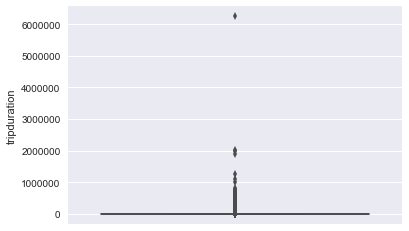

In [10]:
%%time
%matplotlib inline

#CitiBikeDataCompiledBackup = CitiBikeDataCompiled
#CitiBikeDataCompiled = CitiBikeDataCompiledBackup

    # BoxPlot tripDuration - Heavy Outliers!
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()
    
    # How Many Greater than 24 hours?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]>86400]))

    # Remove > 24 Hours
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]<86400]

Once outliers are removed, we run the boxplot again, still seeing skewness in results. To try to mitigate this left-skew distribution, we decide to take a log transform on this attribute. 

Wall time: 1.11 s


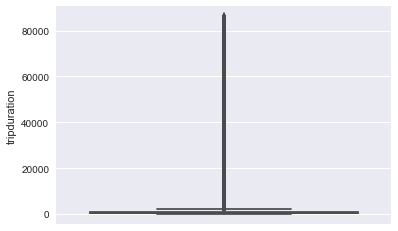

In [11]:
%%time
%matplotlib inline

    # BoxPlot Trip Duration AFTER removal of outliers
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()

    # Log Transform Column Added
CitiBikeDataCompiled["tripdurationLog"] = CitiBikeDataCompiled["tripduration"].apply(np.log)


Wall time: 1.1 s


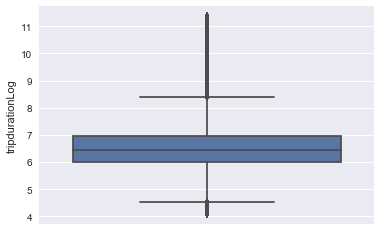

In [12]:
%%time
%matplotlib inline

    # BoxPlot TripDurationLog
sns.boxplot(y = "tripdurationLog", data = CitiBikeDataCompiled)
sns.despine()

**Age**

Similarly, we look at the distribution of Age in our dataset. Interestingly, it seems we have several outlier observations logging their birth year far enough back to cause their age to compute as 115 years old. Possible reasons for these outlier ages could be data entry errors by those who do not enjoy disclosing personal information, or possibly account sharing between a parent and a child - rendering an inaccurate data point to those actually taking the trip. Our target demographic for this study are those individuals under 65 years of age, given that they are the likely age groups to be in better physical condition for the bike share service. Given this target demographic, and the poor entries causing extreme outliers, we have chosen to limit out dataset to observations up to 65 years of age. This change removed an additional 53824 records from the dataset.

53824
Wall time: 4.17 s


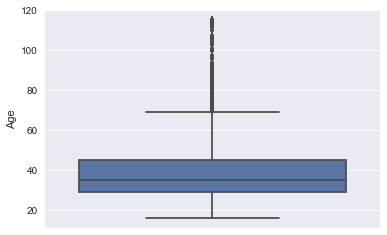

In [13]:
%%time
%matplotlib inline

    # BoxPlot Age - Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()
    
    # How Many Greater than 65 years old?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]>65]))

    # Remove > 65 years old
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]<=65]


Wall time: 2.01 s


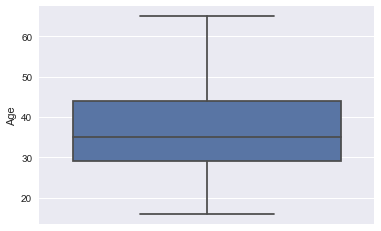

In [14]:
%%time
%matplotlib inline

    # BoxPlot Age - removed Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()

###### Record Sampling to 500,000 Records
Given the extremely large volume of data collected, we have have decided to try to sample down to ~ 1/10th of the original dataset for a total of 500,000 records. Before taking this action, however we wanted to ensure that we keep data proportions reasonable for analysis and ensure we do not lose any important demographic in our data.

Below we compute the percentage of our Dataset that comprises of Customers vs. Subscribers. We note, that 87.6% of the data consists of Subscriber users whereas the remaining 12.4% resemble Customers. 

,usertype,count
0,Customer,680796
1,Subscriber,4827216


Wall time: 538 ms


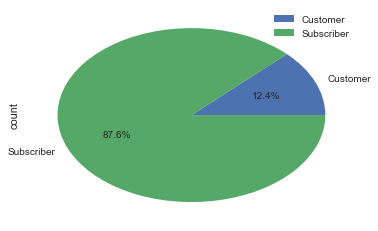

In [15]:
%%time
%matplotlib inline
UserTypeDist = pd.DataFrame({'count' : CitiBikeDataCompiled.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')

In our Sample Dataset for this analysis, we have chosen to oversample the Customer observations to force a 50/50 split between the two classifications. This will help reduce bias in the model towards Subscribers simply due to the distribution of data in the sample.

We are able to compute the sample size for each usertype and then take a random sample within each group. Below you will see that our sampled distribution matches the chosen 50/50 split between Customers and Subscriber Usertypes. 

500000


,usertype,count
0,Customer,250000
1,Subscriber,250000


Wall time: 4.88 s


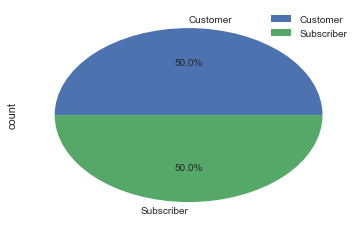

In [16]:
%%time
SampleSize = 500000

CustomerSampleSize_Seed   = int(round(SampleSize * 50.0 / 100.0,0))
SubscriberSampleSize_Seed = int(round(SampleSize * 50.0 / 100.0,0))

CitiBikeCustomerDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Customer'].sample(n=CustomerSampleSize_Seed, replace = False, random_state = CustomerSampleSize_Seed)
CitiBikeSubscriberDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Subscriber'].sample(n=SubscriberSampleSize_Seed, replace = False, random_state = SubscriberSampleSize_Seed)

CitiBikeDataSampled_5050 = pd.concat([CitiBikeCustomerDataSampled,CitiBikeSubscriberDataSampled])

print(len(CitiBikeDataSampled_5050))

UserTypeDist = pd.DataFrame({'count' : CitiBikeDataSampled_5050.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')



### Create a Logistic Regression(LR) Model
##### Prepping Data for Analysis

Now that we have the dataset sampled, we still have some legwork necessary to convert our categorical attributes into integer values. Below we walk through this process for the following Attributes:
- start_station_name
- end_station_name
- gender
- DayOfWeek
- TimeOfDay

Once these 5 attributes have been encoded using OneHotEncoding, we have added 79 attributes into our dataset for analysis in our model.

***Start Station Name***

Due to the extremely large quantity of start stations in our dataset (330 stations), we were required to reduce this dimension down to a manageable size. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 start stations for Subscribers / Customers separately, we found that there were 9 overlapping stations, producing a final list of 31 stations. While encoding our start_station_name integer columns, we limit the number of columns to these stations identified.

In [17]:
%%time
    
    #How many Start Stations are there?
print(len(CitiBikeDataSampled_5050["start_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
startstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubStartStations = startstationsubfreq.head(20)

del startstationsubfreq

    # Top 15 Start Station for Customer Users 
startstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustStartStations = startstationcustfreq.head(20)

del startstationcustfreq

    #Concat Subscribers and Customers
TopStartStations = pd.DataFrame(pd.concat([TopSubStartStations,TopCustStartStations])["start_station_name"].drop_duplicates()).reset_index()    
print(len(TopStartStations))
display(TopStartStations[["start_station_name"]])

del TopStartStations
del TopSubStartStations
del TopCustStartStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.start_station_name,prefix='start_station_name')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["start_station_name_Pershing Square N", "start_station_name_E 17 St & Broadway", "start_station_name_8 Ave & W 31 St", "start_station_name_Lafayette St & E 8 St", "start_station_name_W 21 St & 6 Ave", "start_station_name_8 Ave & W 33 St", "start_station_name_W 20 St & 11 Ave", "start_station_name_Broadway & E 14 St", "start_station_name_Broadway & E 22 St", "start_station_name_W 41 St & 8 Ave", "start_station_name_Cleveland Pl & Spring St", "start_station_name_University Pl & E 14 St", "start_station_name_West St & Chambers St", "start_station_name_E 43 St & Vanderbilt Ave", "start_station_name_Broadway & W 24 St", "start_station_name_Greenwich Ave & 8 Ave", "start_station_name_W 18 St & 6 Ave", "start_station_name_Broadway & W 60 St", "start_station_name_Pershing Square S", "start_station_name_W 33 St & 7 Ave", "start_station_name_Central Park S & 6 Ave", "start_station_name_Centre St & Chambers St", "start_station_name_Grand Army Plaza & Central Park S", "start_station_name_Vesey Pl & River Terrace", "start_station_name_Broadway & W 58 St", "start_station_name_West Thames St", "start_station_name_12 Ave & W 40 St", "start_station_name_9 Ave & W 14 St", "start_station_name_W 14 St & The High Line", "start_station_name_State St", "start_station_name_Broadway & Battery Pl"]]),axis=1) # add back into the dataframe

del AttSplit

330
31


,start_station_name
0,Pershing Square N
1,E 17 St & Broadway
2,8 Ave & W 31 St
3,Lafayette St & E 8 St
4,W 21 St & 6 Ave
5,8 Ave & W 33 St
6,W 20 St & 11 Ave
7,Broadway & E 14 St
8,Broadway & E 22 St
9,W 41 St & 8 Ave


Wall time: 1.47 s


***End Station Name***

Similarly, we have an extremely large quantity of end stations in our dataset (330 stations). We were required to reduce this dimension down to a manageable size. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 end stations for Subscribers / Customers separately, we found that there were 7 overlapping stations, producing a final list of 33 stations. While encoding our end_station_name integer columns, we limit the number of columns to these stations identified.

In [18]:
%%time
    
    #How many End Stations are there?
print(len(CitiBikeDataSampled_5050["end_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
endstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubendStations = endstationsubfreq.head(20)

del endstationsubfreq

    # Top 15 Start Station for Customer Users 
endstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustendStations = endstationcustfreq.head(20)

del endstationcustfreq

    #Concat Subscribers and Customers
TopendStations = pd.DataFrame(pd.concat([TopSubendStations,TopCustendStations])["end_station_name"].drop_duplicates()).reset_index()    
print(len(TopendStations))
display(TopendStations[["end_station_name"]])

del TopendStations
del TopSubendStations
del TopCustendStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.end_station_name,prefix='end_station_name')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["end_station_name_E 17 St & Broadway", "end_station_name_Lafayette St & E 8 St", "end_station_name_8 Ave & W 31 St", "end_station_name_W 21 St & 6 Ave", "end_station_name_Pershing Square N", "end_station_name_W 20 St & 11 Ave", "end_station_name_Broadway & E 14 St", "end_station_name_Broadway & E 22 St", "end_station_name_University Pl & E 14 St", "end_station_name_W 41 St & 8 Ave", "end_station_name_West St & Chambers St", "end_station_name_Cleveland Pl & Spring St", "end_station_name_Greenwich Ave & 8 Ave", "end_station_name_E 43 St & Vanderbilt Ave", "end_station_name_Broadway & W 24 St", "end_station_name_W 18 St & 6 Ave", "end_station_name_MacDougal St & Prince St", "end_station_name_Carmine St & 6 Ave", "end_station_name_8 Ave & W 33 St", "end_station_name_2 Ave & E 31 St", "end_station_name_Central Park S & 6 Ave", "end_station_name_Centre St & Chambers St", "end_station_name_Grand Army Plaza & Central Park S", "end_station_name_Broadway & W 60 St", "end_station_name_Broadway & W 58 St", "end_station_name_12 Ave & W 40 St", "end_station_name_Vesey Pl & River Terrace", "end_station_name_W 14 St & The High Line", "end_station_name_9 Ave & W 14 St", "end_station_name_West Thames St", "end_station_name_State St", "end_station_name_Old Fulton St", "end_station_name_South End Ave & Liberty St"]]),axis=1) # add back into the dataframe

del AttSplit

330
33


,end_station_name
0,E 17 St & Broadway
1,Lafayette St & E 8 St
2,8 Ave & W 31 St
3,W 21 St & 6 Ave
4,Pershing Square N
5,W 20 St & 11 Ave
6,Broadway & E 14 St
7,Broadway & E 22 St
8,University Pl & E 14 St
9,W 41 St & 8 Ave


Wall time: 1.89 s


**Gender, DayOfWeek, and TimeOfDay**

The rest of our encoding attributes {Gender, DayOfWeek, and TimeOfDay} have the following value permutations. These permutations will be encoded as individual integer columns as well.

- Gender:    {0 = unknown, 1 = male, 2 = female}
- DayOfWeek: {Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday}
- TimeOfDay: {Morning, Midday, Afternoon, Evening, Night}

With these encodings complete, our final dataset to cross-validate on test/train datasets is complete.

In [19]:
%%time

    #Split gender Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.gender,prefix='gender')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split DayOfWeek Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.DayOfWeek,prefix='DayOfWeek')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split TimeOfDay Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.TimeOfDay,prefix='TimeOfDay')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

display(CitiBikeDataSampled_5050.head())


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age,tripdurationLog,start_station_name_Pershing Square N,start_station_name_E 17 St & Broadway,start_station_name_8 Ave & W 31 St,start_station_name_Lafayette St & E 8 St,start_station_name_W 21 St & 6 Ave,start_station_name_8 Ave & W 33 St,start_station_name_W 20 St & 11 Ave,start_station_name_Broadway & E 14 St,start_station_name_Broadway & E 22 St,start_station_name_W 41 St & 8 Ave,start_station_name_Cleveland Pl & Spring St,start_station_name_University Pl & E 14 St,start_station_name_West St & Chambers St,start_station_name_E 43 St & Vanderbilt Ave,start_station_name_Broadway & W 24 St,start_station_name_Greenwich Ave & 8 Ave,start_station_name_W 18 St & 6 Ave,start_station_name_Broadway & W 60 St,start_station_name_Pershing Square S,start_station_name_W 33 St & 7 Ave,start_station_name_Central Park S & 6 Ave,start_station_name_Centre St & Chambers St,start_station_name_Grand Army Plaza & Central Park S,start_station_name_Vesey Pl & River Terrace,start_station_name_Broadway & W 58 St,start_station_name_West Thames St,start_station_name_12 Ave & W 40 St,start_station_name_9 Ave & W 14 St,start_station_name_W 14 St & The High Line,start_station_name_State St,start_station_name_Broadway & Battery Pl,end_station_name_E 17 St & Broadway,end_station_name_Lafayette St & E 8 St,end_station_name_8 Ave & W 31 St,end_station_name_W 21 St & 6 Ave,end_station_name_Pershing Square N,end_station_name_W 20 St & 11 Ave,end_station_name_Broadway & E 14 St,end_station_name_Broadway & E 22 St,end_station_name_University Pl & E 14 St,end_station_name_W 41 St & 8 Ave,end_station_name_West St & Chambers St,end_station_name_Cleveland Pl & Spring St,end_station_name_Greenwich Ave & 8 Ave,end_station_name_E 43 St & Vanderbilt Ave,end_station_name_Broadway & W 24 St,end_station_name_W 18 St & 6 Ave,end_station_name_MacDougal St & Prince St,end_station_name_Carmine St & 6 Ave,end_station_name_8 Ave & W 33 St,end_station_name_2 Ave & E 31 St,end_station_name_Central Park S & 6 Ave,end_station_name_Centre St & Chambers St,end_station_name_Grand Army Plaza & Central Park S,end_station_name_Broadway & W 60 St,end_station_name_Broadway & W 58 St,end_station_name_12 Ave & W 40 St,end_station_name_Vesey Pl & River Terrace,end_station_name_W 14 St & The High Line,end_station_name_9 Ave & W 14 St,end_station_name_West Thames St,end_station_name_State St,end_station_name_Old Fulton St,end_station_name_South End Ave & Liberty St,gender_0,gender_1,gender_2,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Midday,TimeOfDay_Morning,TimeOfDay_Night
178325,2023,2013-07-07 14:25:39,2013-07-07 14:59:22,245,Myrtle Ave & St Edwards St,40.693270,-73.977039,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,17767,Customer,0,0,1.760372,Sunday,Afternoon,0,0.00,0.0,85,92,78,0,7.612337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
112533,383,2013-10-09 20:27:55,2013-10-09 20:34:18,334,W 20 St & 7 Ave,40.742388,-73.997262,509,9 Ave & W 22 St,40.745497,-74.001971,18523,Customer,0,0,0.327278,Wednesday,Evening,0,0.00,0.0,58,62,53,0,5.948035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
199683,634,2013-09-01 17:40:41,2013-09-01 17:51:15,363,West Thames St,40.708347,-74.017134,3002,South End Ave & Liberty St,40.711512,-74.015756,20173,Customer,0,0,0.230075,Sunday,Evening,0,0.00,0.0,80,84,75,0,6.452049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Wall time: 2.78 s


##### Build Test & Train Datasets

With our final encoded dataset complete, we begin splitting the data into Test vs Train datasets. The test dataset size for this analysis is 20% of the original data (e.g. 100,000 records). We have utilized a random_state seed equal to the length of the original sampled dataset to ensure reproducible results. By splitting the data into three separate Test vs Train datasets, we are able to cross-validate results on different random samples.

In our first approach to fitting our model, we decided to include all attributes - only excluding those attributes otherwise accommodated for by other integer encodings, time aggregates, or transformed values. 

This initial fit / prediction produced what at first was unexpected results, a {99.991, 99.995, 99.996} % Accuracy rating across the three prediction iterations!! We knew that there must be something abnormal occurring, so we dug into the attributes included in the model. Referencing back to our findings during exploratory data analysis, we know that customers did not provide all of the same demographic information as subscribing members. Due to this, the LR model is able to easily discover whether the user is a customer or not based on these demographic attributes {Age, Birth Year, Gender}. Because of these missing demographic values, we are not able to include them in the model. We will continue to explore our LR model with modified input variables.

*(Note: Below code adapted and modified from MSDS 7331 Data Mining Git Repository Notebook 4)*

In [20]:
%%time

## Create function to create sample test/train datasets with inputs of:
    ## original dataset, 
    ## explanatory dataset (removing appropriate columns not included in model), 
    ## random seed value
def create_sample(Data, dropCols, seed):
    if 'usertype' in Data:
        y = Data['usertype'].values # get the labels we want
        #del CitiBikeDataSampled_5050['usertype'] # get rid of the class label
        X = Data.drop(dropCols, axis = 1).values
        y = np.where(y == 'Subscriber', 1, 0)

    # to use the cross validation object in scikit learn, we need to grab an instance
    #    of the object and set it up. This object will be able to split our data into 
    #    training and testing splits
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit(n=num_instances,
                             n_iter=num_cv_iterations,
                             test_size  = 0.2,
                             random_state = seed)

    return cv_object, X, y

## Create function to Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
def test_LRModel(cv_object, X, y):

    lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

    iter_num=0

    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set preditions
        
        ytestnames = np.where(y[test_indices] == 1, 'Subscriber', 'Customer')
        yhatnames  = np.where(y_hat == 1, 'Subscriber', 'Customer')
        
        # print the accuracy and confusion matrix 
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
        print("confusion matrix\n", pd.crosstab(ytestnames, yhatnames, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("log_loss = ", log_loss(y[test_indices], y_hat))
        #print("roc_auc_score = ", roc_auc_score(y[test_indices], y_hat))
        #print("F-score = ", mt.f1_score(y[test_indices], y_hat))
    
    del cv_object
    return lr_clf, X[train_indices],y[train_indices], X[test_indices], y[test_indices], y_hat





Wall time: 0 ns


In [21]:
%%time

# define random seed value to re-use
seed = len(CitiBikeDataSampled_5050)

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, and original columns for encoded binary columns
cv_object_All, X_All, y_All = create_sample(CitiBikeDataSampled_5050, 
                                            ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration'], 
                                            seed)
print(cv_object_All)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_All, X_Train_All, y_Train_All, x_Test_All, y_Test_All, y_hat_All = test_LRModel(cv_object_All, X_All, y_All)

del X_All, y_All

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)
====Iteration 0  ====
accuracy 0.99991
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       49825           9   49834
Subscriber         0       50166   50166
All            49825       50175  100000
log_loss =  0.00310856183931
====Iteration 1  ====
accuracy 0.99995
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       49946           5   49951
Subscriber         0       50049   50049
All            49946       50054  100000
log_loss =  0.00172697879962
====Iteration 2  ====
accuracy 0.99996
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       50271           4   50275
Subscriber         0       49725   49725
All            50271       49729  100000
log_loss =  0.00138158303969
Wall time: 49.9 s


With the previous model rendering such suspicous results and our recollection of missing demographic data, we have re-fitted our model after removing the below additional attributes:
- Age
- gender_0
- gender_1
- gender_2
- birth year

With these additional attributes removed, our accuracy ratings decreased to {74.526, 74.675, 74.725} % across the three test / train iterations. Although the accuracy decreased, we feel the *value* of these results are much more substantial. Walking through Iteration 0 results we can see from the Confusion matrix that  of the 49,834 Customers in the test dataset, we correctly predicted 37,327. On the otherhand, we incorrectly predicted 12,507 Customers as Subscribers. These 12,507 Customers, which we think meet the criteria for typical Subscribers are the perfect targets for CitiBike promotions, discounts, adverts, and other means of trying to get them to start subscribing. 

In [22]:
%%time

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
cv_object_RemABYG, X_RemABYG, y_RemABYG = create_sample(CitiBikeDataSampled_5050, 
                                                        ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], 
                                                        seed)
print(cv_object_RemABYG)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_RemABYG, X_Train_RemABYG, y_Train_RemABYG, x_Test_RemABYG, y_Test_RemABYG, y_hat_RemABYG = test_LRModel(cv_object_RemABYG, X_RemABYG, y_RemABYG)

del X_RemABYG, y_RemABYG

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)
====Iteration 0  ====
accuracy 0.74526
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37327       12507   49834
Subscriber     12967       37199   50166
All            50294       49706  100000
log_loss =  8.79850790449
====Iteration 1  ====
accuracy 0.74675
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37278       12673   49951
Subscriber     12652       37397   50049
All            49930       50070  100000
log_loss =  8.74704645499
====Iteration 2  ====
accuracy 0.74725
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37662       12613   50275
Subscriber     12662       37063   49725
All            50324       49676  100000
log_loss =  8.72977658704
Wall time: 1min 24s


Although we are fairly happy with the accuracy of the model once simply removing the missing demographic attributes, we want to ensure we are maximizing the efficiency of our model fit. We want to find a model which maximizes the Positive Subscriber matches in order to also maximize the number of correctly assigned false positive Customer predictions. To do this we have built the model fit various times by removing the below attributes in different combinations. 
- start_station_latitude
- start_station_longitude
- end_station_latitude
- end_station_longitude
- bikeid
- LinearDistance

For the purpose of this report, we have chosen to discuss the additional removal of LinearDistance and bikeid to interpret, however all combinations tried produced similar results. With an accuracy ratings of {73.796, 74.078, 73.987} %, this model fit produces less accurate overall results. Furthermore, when looking at values for log_loss statistics, the previous model rendered a more effective model fit. Interested to maximize our positive Subscriber predictions, the previous model's iteration 0 Subscriber Positive predictions are at 74% compared to this model's 73% accuracy for Subscribers. These several facts lead to our conclusion to include all attributes *except* the missing value demographic attributes moving forward in our analysis.


In [23]:
%%time

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
    # AND LinearDistance
    # AND BikeID
cv_object_RemABYG_LDBID, X_RemABYG_LDBID, y_RemABYG_LDBID = create_sample(CitiBikeDataSampled_5050, 
                                                                          ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year','LinearDistance', 'bikeid'], 
                                                                          seed)
print(cv_object_RemABYG_LDBID)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_RemABYG_LDBID, X_Train_RemABYG_LDBID, y_Train_RemABYG_LDBID, x_Test_RemABYG_LDBID, y_Test_RemABYG_LDBID, y_hat_RemABYG_LDBID = test_LRModel(cv_object_RemABYG_LDBID, X_RemABYG_LDBID, y_RemABYG_LDBID)

del X_RemABYG_LDBID, y_RemABYG_LDBID

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)
====Iteration 0  ====
accuracy 0.73796
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37173       12661   49834
Subscriber     13543       36623   50166
All            50716       49284  100000
log_loss =  9.05064220355
====Iteration 1  ====
accuracy 0.74078
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37228       12723   49951
Subscriber     13199       36850   50049
All            50427       49573  100000
log_loss =  8.95324334987
====Iteration 2  ====
accuracy 0.73987
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37529       12746   50275
Subscriber     13267       36458   49725
All            50796       49204  100000
log_loss =  8.9846738203
Wall time: 57.2 s


With our final model variables selected, we have one parameter in our LR fit to manipulate for accuracies. We have chosen to manipulate the cost variable within our logistic regression analyzing accuracies at {1.0, .01, .05, 5}. Calculations show that our original default of Cost = 1 produced the highest accuracy ratings in 2 out of 3 iterations. Due to this, we have chosen to leave our model alone, as was originally computed.

In [24]:
%%time

from sklearn.cross_validation import cross_val_score

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
cv_object_RemABYG, X_RemABYG, y_RemABYG = create_sample(CitiBikeDataSampled_5050, 
                                                        ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], 
                                                        seed)

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf, X_RemABYG, y=y_RemABYG, cv=cv_object_RemABYG) # this also can help with parallelism
    return accuracies

list = [] 

list.append(lr_explor(cost = 1.0))
list.append(lr_explor(cost = .01))
list.append(lr_explor(cost = .05))
list.append(lr_explor(cost = 5))

test = pd.DataFrame(pd.concat([pd.DataFrame(['Cost1.0', 'Cost0.01', 'Cost0.05', 'Cost5.0']),
                               pd.DataFrame(list)], axis = 1).reindex())
test.columns = ['Cost','Iteration 0', 'Iteration 1', 'Iteration 2']
display(test)


,Cost,Iteration 0,Iteration 1,Iteration 2
0,Cost1.0,0.74526,0.74675,0.74725
1,Cost0.01,0.74482,0.74643,0.74738
2,Cost0.05,0.74511,0.74628,0.74716
3,Cost5.0,0.74497,0.74672,0.74735


Wall time: 3min 53s


In [25]:
del X_RemABYG, y_RemABYG

### Create a Support Vector Machine(SVM) Model

In addition to generating a logistic regression model to classify CitiBike rider types based on riding behaviors, we would also like to generate a support vector machine (SVM) model for classification comparison. By utilizing the same 80/20 training/test split samples used during logistic regression model generation, we expect to be able to produce model results very similar to those of logistic regression.

To best compare SVM performance against logistic regression, we choose to generate SVM models for all three data set versions modeled in the logistic regression section above. As a reminder, these data sets are as follows: The first data set consists of all attributes; the second data set has Age, Birth Year, and Gender removed; and the last data set has Age, Birth Year, Gender, Linear Trip Distance, and Bike ID removed. Generating SVM models for all three data sets will allow us to compare the SVM and Logistic Regression approaches under various data set conditions.

Initially, our team attempted to generate standard SVM models on the data sets. However, with 500,000 sample trips consisting of 105 attributes each (after removing unnecessary/duplicate parameters as was done for logistic regression), SVM model generation proved to be too time consuming. For this reason, stochastic gradient descent classification is pursued instead. An example cell block of our SVM model attempt for the first data set is shown below.

*(Note that code within this section was adapted and modified from the MSDS 7331 Notebook 4 SVM tutorial)*

In [26]:
%%time

## Create function to fit SVM model and output model accuracy, confusion matrix, and log-loss value.
## Inputs consist of X and Y training data and X and Y test data.
def SVMfit(X_Train, y_Train, x_Test, y_Test):
    scl_obj = StandardScaler()
    scl_obj.fit(X_Train)
    
    X_train_scaled = scl_obj.transform(X_Train) # apply to training
    X_test_scaled = scl_obj.transform(x_Test)
    
    # Train the SVM model
    svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
    svm_clf.fit(X_train_scaled, y_Train)  # train object
    
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
    
    acc = mt.accuracy_score(y_Test,y_hat)
    
    ytestnames = np.where(y_Test == 1, 'Subscriber', 'Customer')
    yhatnames  = np.where(y_hat == 1, 'Subscriber', 'Customer')
    
    print("====Iteration",iter_num," ====")
    print('accuracy:', acc )
    print("confusion matrix\n", pd.crosstab(ytestnames, yhatnames, rownames = ['True'], colnames = ['Predicted'], margins = True))

    return svm_clf

## Commented out since regular SVM takes too long to run (14+ hours)
#SVMfit(X_Train = X_Train_All, y_Train = y_Train_All, x_Test = x_Test_All, y_Test = y_Test_All)

#SVMfit(X_Train = X_Train_RemABYG, y_Train = y_Train_RemABYG, x_Test = x_Test_RemABYG, y_Test = y_Test_RemABYG)

#SVMfit(X_Train = X_Train_RemABYG_LDBID, y_Train = y_Train_RemABYG_LDBID, x_Test = x_Test_RemABYG_LDBID,
#       y_Test = y_Test_RemABYG_LDBID)

Wall time: 0 ns


Since stochastic gradient descent classification is to be used for each data set variation in lieu of SVM modeling in our case, the following function is created to simplify model generation. The function receives independent and dependent variable training and test data for a given data set, normalizes the data, fits it to a stochastic gradient classifier model, and then prints model accuracy, confusion matrix details, and the log-loss value. Notice a seed value is provided for repeatability purposes.

In [27]:
%%time

## Create function to fit SGDClassifier object and output model accuracy, confusion matrix, and log-loss value.
## Inputs consist of X and Y training data and X and Y test data.
def SGDfit(X_Train, y_Train, x_Test, y_Test):
    regularize_const = 0.1
    seed = len(CitiBikeDataSampled_5050)
    svm_sgd = SGDClassifier(alpha=regularize_const, l1_ratio=0.0, n_jobs=-1, random_state = seed)

    scl = StandardScaler()

    svm_sgd.fit(scl.fit_transform(X_Train), y_Train)
    yhat = svm_sgd.predict(scl.transform(x_Test))
    
    acc = mt.accuracy_score(y_Test,yhat)
    
    ytestnames = np.where(y_Test == 1, 'Subscriber', 'Customer')
    yhatnames  = np.where(yhat == 1, 'Subscriber', 'Customer')
    
    print("====Iteration",iter_num," ====")
    print('SVM:', acc)
    print("confusion matrix\n", pd.crosstab(ytestnames, yhatnames, rownames = ['True'], colnames = ['Predicted'], margins = True))
    print("log_loss = ", log_loss(y_Test, yhat))

    return None

Wall time: 0 ns


The first of the SVM models trained using stochastic gradient descent is that of the first data set in which "all" attributes are present. As was observed when generating the data set's logistic regression model above, the SVM accuracy is nearly perfect with accuracy ratings of {99.998, 99.996, 99.995} % across the three test / train iterations due to the included Age, Birth Year, and Gender attributes. Again, even though this appears to be a fantastic model and the log-loss value is extremely low {0.0007, 0.0014, 0.0017}, we know this model is invalid based on our domain knowledge, or data set understanding. These three demographic attributes are effectively masking all other attributes only because birth year and gender data are typically missing for customers but included for subscribers. In other words, the SVM model learns to identify riders with an age of 0 years or unknown gender as customers (Note Age/BirthYear/Gender data is present for 5 Customers only, which accounts for the {2, 4, 5} mis-classified riders). Removing these "give-away" attributes will produce a realistic model that is not skewed by missing data.

In [28]:
%%time

cv_object_All, X_All, y_All = create_sample(CitiBikeDataSampled_5050, 
                                            ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration'], 
                                            seed)
print(cv_object_All)

iter_num = 0

for iter_num, (train_indices, test_indices) in enumerate(cv_object_All):
    SGDfit(X_Train = X_All[train_indices], y_Train = y_All[train_indices],
           x_Test = X_All[test_indices], y_Test = y_All[test_indices])

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)


D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


====Iteration 0  ====
SVM: 0.99998
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       49832           2   49834
Subscriber         0       50166   50166
All            49832       50168  100000
log_loss =  0.000690791519848
====Iteration 1  ====
SVM: 0.99996
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       49947           4   49951
Subscriber         0       50049   50049
All            49947       50053  100000
log_loss =  0.00138158303969
====Iteration 2  ====
SVM: 0.99995
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       50270           5   50275
Subscriber         0       49725   49725
All            50270       49730  100000
log_loss =  0.00172697879962
Wall time: 42.9 s


The second SVM model generated using stochastic gradient descent is for the data set with Age, Birth Year, and Gender attributes removed. As was observed during logistic regression generation, model accuracy is still strong but far more realistic values of {74.121, 74.339, 74.44} % across the three test / train iterations are given now that we've accounted for misleading attributes. Walking through Iteration 0 results, 49,834 Customers in the data set, 37,548 were correctly identified but 12,286 were incorrectly classified as Subscribers. Similarly, of the 50,166 Subscribers, 36,573 were correctly identified as such but 13,593 were incorrectly classified as Customers. The log-loss produced is modestly low at {8.94, 8.86, 8.83}. This is of course much larger than the model's above, but, again, the previous model was invalid since Age, Birth Year, and Gender attributes were included. This model is much better representative of rider attributes while ignoring attributes containing missing data unique to the Customer user type.

In [29]:
%%time

cv_object_RemABYG, X_RemABYG, y_RemABYG = create_sample(CitiBikeDataSampled_5050, 
                                                        ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], 
                                                        seed)
print(cv_object_RemABYG)

iter_num = 0

for iter_num, (train_indices, test_indices) in enumerate(cv_object_RemABYG):
    SGDfit(X_Train = X_RemABYG[train_indices], y_Train = y_RemABYG[train_indices],
           x_Test = X_RemABYG[test_indices], y_Test = y_RemABYG[test_indices])

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)


D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


====Iteration 0  ====
SVM: 0.74121
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37548       12286   49834
Subscriber     13593       36573   50166
All            51141       48859  100000
log_loss =  8.93838818178
====Iteration 1  ====
SVM: 0.74339
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37561       12390   49951
Subscriber     13271       36778   50049
All            50832       49168  100000
log_loss =  8.86309448082
====Iteration 2  ====
SVM: 0.7444
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37945       12330   50275
Subscriber     13230       36495   49725
All            51175       48825  100000
log_loss =  8.8282098369
Wall time: 39.3 s


The final SVM model generated using stochastic gradient descent is for the data set with Age, Birth Year, Gender, Trip Linear Distance, and Bike ID removed. These latter two attributes were removed because they were deemed potentially insignficant when classifying user types. Surprisingly, model accuracy decreases slightly ({73.728, 73.974, 74.002} % accurate) when removing these last two attributes. The confusion matrix in iteration 0 indicates that while 37,594 riders were correctly identified as Customers, 12,240 Customers were incorrectly identified as Subscribers; similarly 36,134 Subscribers were correctly identified as such but 14,032 Subscribers were mis-classified as Customers. Log-loss is slightly higher {9.07, 8.99, 8.98} than the model in which only Age, Birth Year, and Gender were removed. This suggests that Trip Linear Distance and Bike ID may have a stronger correlation with user type than expected otherwise.

In [30]:
%%time

cv_object_RemABYG_LDBID, X_RemABYG_LDBID, y_RemABYG_LDBID = create_sample(CitiBikeDataSampled_5050, 
                                                                          ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year','LinearDistance', 'bikeid'], 
                                                                          seed)
print(cv_object_RemABYG_LDBID)

iter_num = 0

for iter_num, (train_indices, test_indices) in enumerate(cv_object_RemABYG_LDBID):
    SGDfit(X_Train = X_RemABYG_LDBID[train_indices], y_Train = y_RemABYG_LDBID[train_indices],
           x_Test = X_RemABYG_LDBID[test_indices], y_Test = y_RemABYG_LDBID[test_indices])

ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=500000)


D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


====Iteration 0  ====
SVM: 0.73728
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37594       12240   49834
Subscriber     14032       36134   50166
All            51626       48374  100000
log_loss =  9.0741252052
====Iteration 1  ====
SVM: 0.73974
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37647       12304   49951
Subscriber     13722       36327   50049
All            51369       48631  100000
log_loss =  8.98916032701
====Iteration 2  ====
SVM: 0.74002
confusion matrix
 Predicted   Customer  Subscriber     All
True                                    
Customer       37975       12300   50275
Subscriber     13698       36027   49725
All            51673       48327  100000
log_loss =  8.97948943763
Wall time: 38.5 s


Of the three SVM models, the data set with only Age, Birth Year, and Gender attributes removed appears to be the best fit due to its higher *valid* accuracy and lowest *valid* log-loss value. This aligns with our findings when classifying user type using logistic regression in the previous section.

### Pros and Cons of LR vs. SVM
Both Logisitic Regression and Support Vector Machines present advantages as well as disadvantages. As might be expected, which approach is best depends on one's data set and problem statement. Our use of both model types with the same data sample set allows us to break down these pros and cons in detail and determine which produces a better fit given our situation. With this in mind, each model type's general advantages and disadvantages are outlined and discussed below.

**General Advantages**

*Logisitic Regression*
- *Simplicity* - The logistic regression model is built in such a way that independent variables are plotted along an x-axis and single-class classification is represented by 0 or 1 on the y-axis. The logit and cost functions are tuned to accurately fit a logistic curve to the data on this x-y plane. By evaluating P(X) via the logit function, we are able to easily determine whether the class is 0 (Customer), in cases when P < 0.5, or 1 (Subscriber), in cases in which P > 0.5. In other words, logistic regression fits all data points as though they were positioned along a continuous function.

- *Small Dimensionality Applications* - Logistic regression works well when there are a smaller number of dimensions and when these attributes do not necessarily determine the response without considering probability of response.

*SVM*
- *Flexible* - Since SVM is capable of fitting a hyperplane among an infinite number of dimensions to create a boundary between classes of various data points, it allows for seperation of data from varying classes even when data sets are very large or contain many attributes.

- *Robust* - In general, SVM is more robust against outliers since it only considers points near the margin as support vectors.

- *Speed (SVM training with Stochastic Gradient Descent)* - Because stochastic gradient descent processes the data in batches and is less precise in it's batch-by-batch approach to deepest descent but still arrives there nonetheless in the end, it is significantly faster than logistic regression and SVM on its own (less resource instensive).

**General Disadvantages**

*Logistic Regression*
- *Speed* - Logistic regression, though faster than straightforward SVM for our data set, is slower in comparison to training a classfier model using stochastic gradient descent.

- *Sensitivity* - In cases when P = ~0.5, logistic regression has difficulty determining classification.

*SVM*
- *Speed (SVM by itself)* - Fitting a SVM model on its own was very slow for our data set. Even after 14 hours of run-time on a quad-core i7 workstation, not even a single model was completely generated.

**The Winner**

Given the general advantages and disadvantages above, we'd now like to discuss both model approaches with respect to our data. These discussions are centered around the data set version in which only Age, Birth Year, and Gender are removed from the originally modeled set. As mentioned above, linear SVM training with stochastic gradient descent for 3x iterations was much faster for our selected data set (~39s) vs. native logistic regression training (~1 min 24s). This time difference is expected to increase exponentially as the number of rides analyzed increases, giving SVM with stochastic gradient descent the upper edge. <span style="color:green">*+1 for SVM with stochastic gradient descent*</span>

On the other hand, however, logistic regression produced accuracy results of {74.52, 74.49, 74.73} % across the three test/train iterations whereas SVM with stochastic gradient descent exhibited accuracy results of {74.121, 74.339, 74.44} %. This slight increase in accuracy among logistic regression models is an interesting observation, especially given logistic regression's added simplicity vs. SVM modelling. A second measure of accuracy employed throughout this analysis has been log-loss. When comparing log-loss among both model types, we expect log-loss values to correspond with model accuracy measures also. As such, logistic regression log-loss values were {8.80, 8.75, 8.73} for each of the three iterations whereas SVM with stochastic gradient values were {8.94, 8.86, 8.83}. As expected, these results correlate with the accuracy scores discussed. <span style="color:blue">*+1 for logistic regression*</span>

The final comparison worth further discussion is that of efficiency. As mentioned in the general advantages and disadvantages above, logistic regression consists of a simpler model than SVM, especially when factoring in stochastic gradient descent to SVM model training. Logistic regression classifies our CitiBike user types by optimizing the log likelihood function; SVM tries to maximize the margin between the closest data points of two classification regions. The fact that stochastic gradient descent is required given our data set dimensions and large number of observations means the model generation process may be deemed less efficient. In the end, the principles of Occam's Razor apply. Therefore, logistic regression without stochastic gradient descent takes the win for our data set.<span style="color:blue">*+1 for logistic regression*</span>

Given its increased accuracy and efficiency/simplicity, we rate logistic regression as being the better model for user type classification using our sample data set of 500,000 rides.

### LR Feature Weightings Explained

With our model settled upon for our Logistic Regression, we need to explore the weights associated with each feature to get an idea of how each component impacts the ultimate prediction. Looking at our logistic model directly, we found, interestingly enough, that the highest weight was placed on the latitude of the station where renters began their trips. Having a high positive weight means that subscribers were more likely located at lower latitudes, but based on our heat maps, this seemed to contradict our initial data exploration. Moreover, the next highest weight in terms of magnitude was a specific station, and while it appeared in the top ten percent of our most visited stations, it's odd that it would be so important.

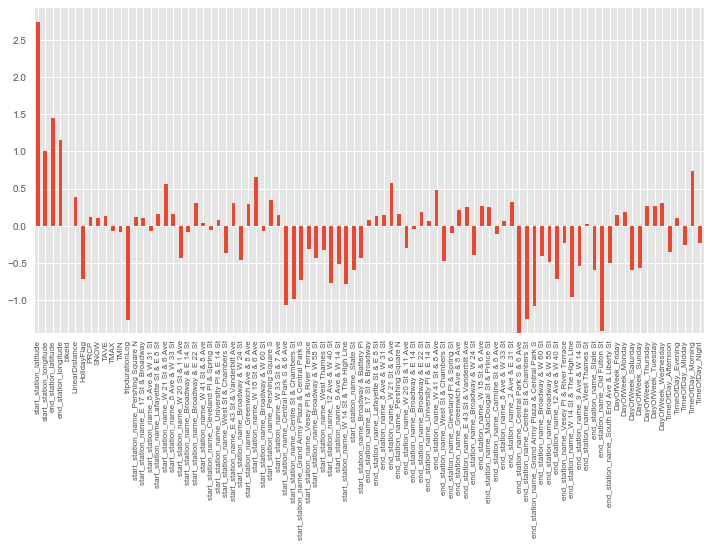

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

lr_weights_raw = lr_clf_RemABYG.coef_.T # take transpose to make a column vector
lr_variable_names = CitiBikeDataSampled_5050.drop(['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], axis = 1).columns
lr_weights = zip(lr_weights_raw,lr_variable_names)

lr_weights_top_15_sorted = sorted(lr_weights, key=lambda x: abs(x[0]), reverse=True)[:15]

lr_weights_top_15_sorted_coef = []
lr_weights_top_15_sorted_names = []
for coef, name in lr_weights_top_15_sorted:
    lr_weights_top_15_sorted_coef.append(coef[0])
    lr_weights_top_15_sorted_names.append(name)

weightsplot = pd.Series(lr_clf_RemABYG.coef_[0], index=lr_variable_names)
weightsplot.plot(kind='bar')
plt.show()
    


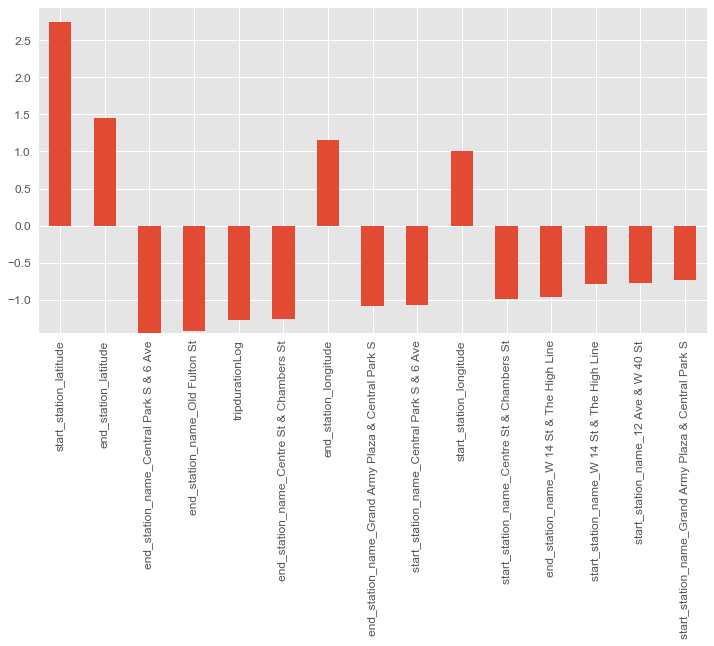

In [32]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

top_15_weights_plot = pd.Series(lr_weights_top_15_sorted_coef, index=lr_weights_top_15_sorted_names)
top_15_weights_plot.plot(kind='bar')
plt.show()


#for coef, name in zip(lr_weights_raw,lr_variable_names):
#    print(name, 'has weight of', coef[0])

After reviewing our dataset once more, we realized that it was likely our weights were compromised due to the fact that we were dealing with a mix of values and quantities that weren't directly comparable. To get a better understanding of how these features were interacting, we decided to attempt to normalize the features, improving our ability to compare these features across their vastly different scales.

This required a refit using the sklearn Standard Scaler training object, but because we're only concerned with the weights and their interactions, we can easily reuse the sets defined in our ShuffleSplit earlier in our regression. However, because we're dealing with scaled and normalized values, we'll use a lower cost value, in this case 0.05 to reflect the expected decrease in variance.

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


accuracy: 0.74725
[[37662 12613]
 [12662 37063]]


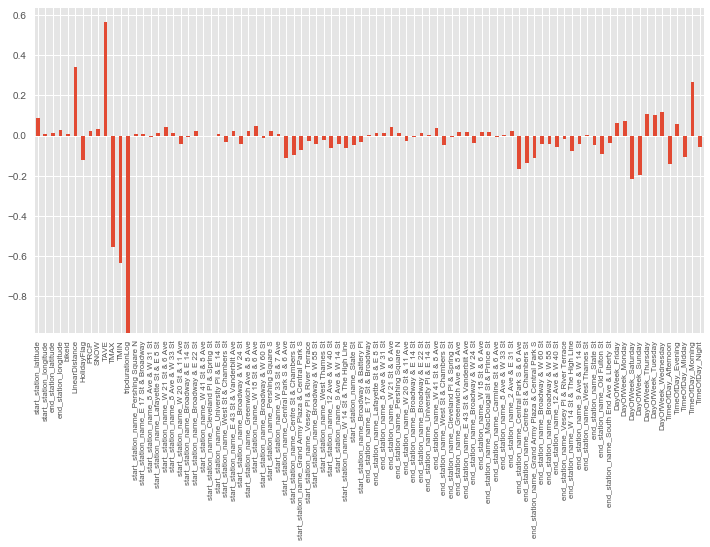

In [33]:
from sklearn.preprocessing import StandardScaler

matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

scl_obj = StandardScaler()
scl_obj.fit(X_Train_RemABYG)

X_train_scaled = scl_obj.transform(X_Train_RemABYG)
X_test_scaled = scl_obj.transform(x_Test_RemABYG)

scalar_lr_clf = LogisticRegression(penalty='l2', C=0.05) # Earlier this cost was 1.0, because we've normalized the dataset, we now can use a lower cost
scalar_lr_clf.fit(X_train_scaled,y_Train_RemABYG)

scalar_y_hat = scalar_lr_clf.predict(X_test_scaled)

scalar_acc = mt.accuracy_score(y_Test_RemABYG, y_hat_RemABYG)
scalar_conf = mt.confusion_matrix(y_Test_RemABYG, y_hat_RemABYG)
print('accuracy:', scalar_acc)
print(scalar_conf)


scalar_weights = zip(scalar_lr_clf.coef_[0],lr_variable_names)

scalar_weights_top_15_sorted = sorted(scalar_weights, key=lambda x: abs(x[0]), reverse=True)[:15]

scalar_weights_top_15_sorted_coef = []
scalar_weights_top_15_sorted_names = []
for coef, name in scalar_weights_top_15_sorted:
    scalar_weights_top_15_sorted_coef.append(coef)
    scalar_weights_top_15_sorted_names.append(name)

scalar_weights = pd.Series(scalar_lr_clf.coef_[0],index=lr_variable_names)
scalar_weights.plot(kind='bar')
plt.show()


The accuracy and prediction matrix closely resembles our earlier regression and SVM models, meaning that the act of normalization did not greatly impact our model, however it did make understanding the weights much easier and, surprisingly, closely resembled some of our previous hypotheses we posited during our inital data gathering.

Perhaps one unique component of these new weights is that the log transform of the trip duration has a negative weight, nearly 1, with the subscriber class. This implies that subscribers spend very little time on their trip, despite the linear distance between stations having a high positive weight. These two features seem to correlate with our earlier observations that subscribers were typically seen commuting rather than touring using the bikes.

Another interesting aspect is the temperature component created after merging Citi Bike rental data with historical weather data. Both the maximum temperature and the minimum temperature have a negative weight with the subscriber class, however the average temperature has a positive weight. If subscribers are commuting, then it might make sense that as the average temperature for the day rises, they're much more likely to make use of their subscription. As it's possible they commute regardless of weather, extreme weathers are not as likely to impact their riding habits and behaviors.

Finally, a few more quick observations based entirely on weight - saturday and sunday rentals both have negative weights in relationship to subscribers, further building upon the idea that subscribers are also generally commuters, and mornings also have a positive weight in regards to subscriber use. This might mean that subscribers are more likely to ride earlier in the morning on weekdays.

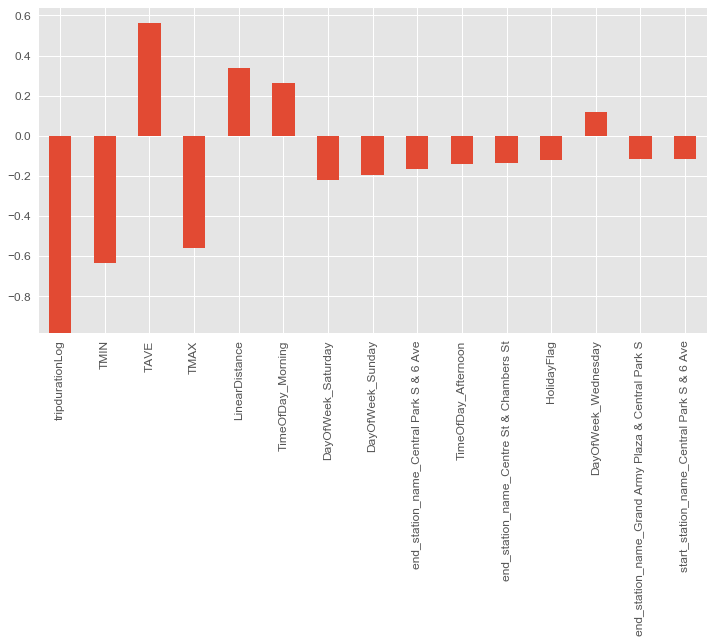

In [34]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

scalar_top_15_weights_plot = pd.Series(scalar_weights_top_15_sorted_coef, index=scalar_weights_top_15_sorted_names)
scalar_top_15_weights_plot.plot(kind='bar')
plt.show()

#zip_vars = zip(scalar_lr_clf.coef_.T,lr_variable_names) # combine attributes
#zip_vars = sorted(zip_vars)

#for coef, name in zip_vars:
#    print(name, 'has weight of', coef[0]) # now print them out

### Support Vectors Explained

Due to the performance issues of the SVM model without SGD, we were unable to capture support vector coefficients previously. In order to do so, we have sub-sampled our 50/50 dataset down to 10,000 observations. We were once again cognizant of our Customer vs. Subscriber distribution in our sample, and ensured to keep our 50/50 split. 

10000


,usertype,count
0,Customer,5000
1,Subscriber,5000


Wall time: 2.44 s


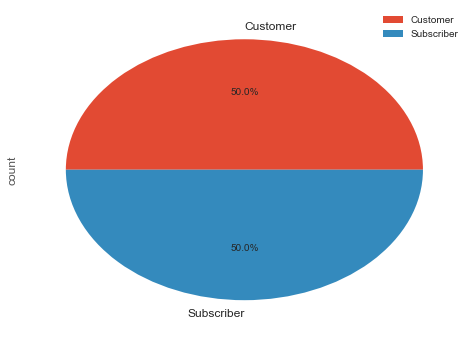

In [35]:
%%time
SampleSize = 10000

CustomerSampleSize_Seed   = int(round(SampleSize * 50.0 / 100.0,0))
SubscriberSampleSize_Seed = int(round(SampleSize * 50.0 / 100.0,0))

CitiBikeCustomerDataSampled = CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].sample(n=CustomerSampleSize_Seed, replace = False, random_state = CustomerSampleSize_Seed)
CitiBikeSubscriberDataSampled = CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].sample(n=SubscriberSampleSize_Seed, replace = False, random_state = SubscriberSampleSize_Seed)

CitiBikeDataSampled_5050_sub = pd.concat([CitiBikeCustomerDataSampled,CitiBikeSubscriberDataSampled])

print(len(CitiBikeDataSampled_5050_sub))

UserTypeDist = pd.DataFrame({'count' : CitiBikeDataSampled_5050_sub.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%', figsize = (8, 6))

With our sub-sampled dataset, we are able to Train and Test our SVM model on our dataset. We have chosen to run SVM model on the dataset version with Age, Birth Year, and Gender removed, which brought out the strongest model in both LR and SGD previously. This model fit, although running on a much smaller dataset, resulted in very similar results to our previous executions. With accuracy ratings of {73.1, 7.47, 74} %, we would once again be able to gain value from our false positive customer matches - introducing promotions, discounts and other ways of gaining subscriber traction.

In [36]:
%%time

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
cv_object_RemABYG, X_RemABYG, y_RemABYG = create_sample(CitiBikeDataSampled_5050_sub, 
                                                        ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], 
                                                        seed)
print(cv_object_RemABYG)

iter_num = 0
svm_clf = 0

for iter_num, (train_indices, test_indices) in enumerate(cv_object_RemABYG):
    svm_clf = SVMfit(X_Train = X_RemABYG[train_indices], y_Train = y_RemABYG[train_indices],
                               x_Test = X_RemABYG[test_indices], y_Test = y_RemABYG[test_indices])

ShuffleSplit(10000, n_iter=3, test_size=0.2, random_state=500000)


D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


====Iteration 0  ====
accuracy: 0.731
confusion matrix
 Predicted   Customer  Subscriber   All
True                                  
Customer         723         267   990
Subscriber       271         739  1010
All              994        1006  2000
====Iteration 1  ====
accuracy: 0.747
confusion matrix
 Predicted   Customer  Subscriber   All
True                                  
Customer         751         273  1024
Subscriber       233         743   976
All              984        1016  2000
====Iteration 2  ====
accuracy: 0.74
confusion matrix
 Predicted   Customer  Subscriber   All
True                                  
Customer         726         242   968
Subscriber       278         754  1032
All             1004         996  2000
Wall time: 28.4 s


Looking at the shape of our support vectors in the last iteration (2) of the SVM test, we see that the original train dataset of 8,000 observations has been reduced to a total of 4,679 support vectors, utilizing 89 features in the model. This constitutes a 41.5% reduction in observations to support vectors supporting our model. Of those 4,679 support vectors, 2341 of them represent Customer Vector Indices wheras 2,338 of them represent Subscriber Vector Indices.

In [37]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(4679, 89)
(4679,)
[2341 2338]


With our SVC model fit in place and support vectors identified, we are able to analyze the weightings of support vector coefficients. Plotting these values, we can see the full spectrum of positive/negative weights on each of the 89 attributes included in the model. To take a closer look at the coefficients with the largest magnitude, we zoom in this plot to the top 15 attributes.

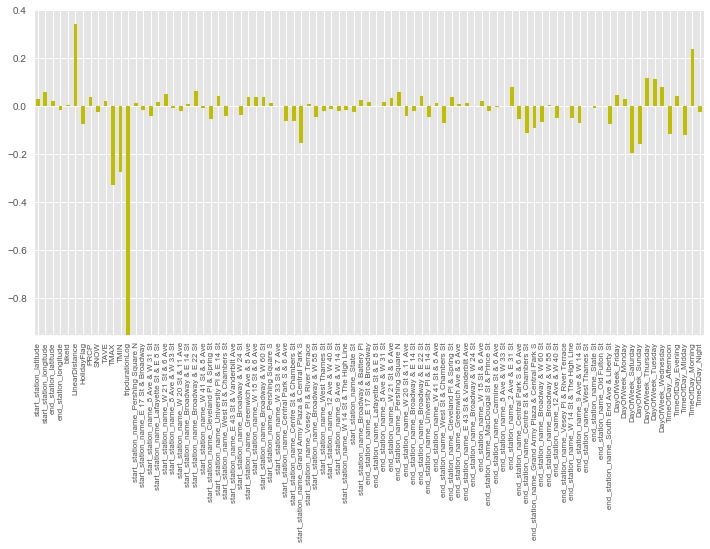

In [38]:
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

# if using linear kernel, these make sense to look at (not otherwise, why?)
# print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=CitiBikeDataSampled_5050_sub.drop(['starttime','stoptime',
                                                                              'start_station_id','start_station_name',
                                                                              'end_station_id','end_station_name',
                                                                              'usertype','gender','DayOfWeek',
                                                                              'TimeOfDay','tripduration','Age',
                                                                              'gender_0','gender_1','gender_2',
                                                                              'birth year'], axis = 1).columns)
weights.plot(kind = 'bar', figsize = (12, 6), color = 'y')

As was expected, we see quite a bit of overlap between our top SVM coefficients and what was found previously in our LR scaled coefficient weightings. TripDurationLog has the strongest impact on determining usertype with a negative weighting, while Linear Distance once again remains positive. This continues to support our theories that Subscribers utilize CitiBike services for commute trips creating shorter rides that travel further. It is likely that Customers utilize the bike service to visit attractions, and then return back near the same station where their car is parked. Similarly, our time segments show consistencies across the two model types, depicting morning start times as common for subscribing members whereas midday/afternoon rides aid to represent customers. Temperature attributes for Minimum and Maximum temperatures also agree with previous LR weightings, depicting higher min/max temperatures as indicators for customer users. Interestingly, average temperature does not show up in our top 15 weights for SVM. Finally, only 2 of the 4 stations match between the two models types.

Perhaps, some of these differences could be due to the significant difference in sample size. In order to analyze SVM support vectors, we had to reduce our original sample of 500,000 by 98%, a 10,000 sample size, due to computational load of the model fit. This reduction in sample size results in analyzing a mere 0.18% of the original dataset collected. There is a good chance that important trends in the data are unrecognizeable since we have eliminated so much. It would be interesting to see, given the time and computational resourses, how this SVM model would compare to LR and SGD models if executed successfully on the full 500,000 samples. 

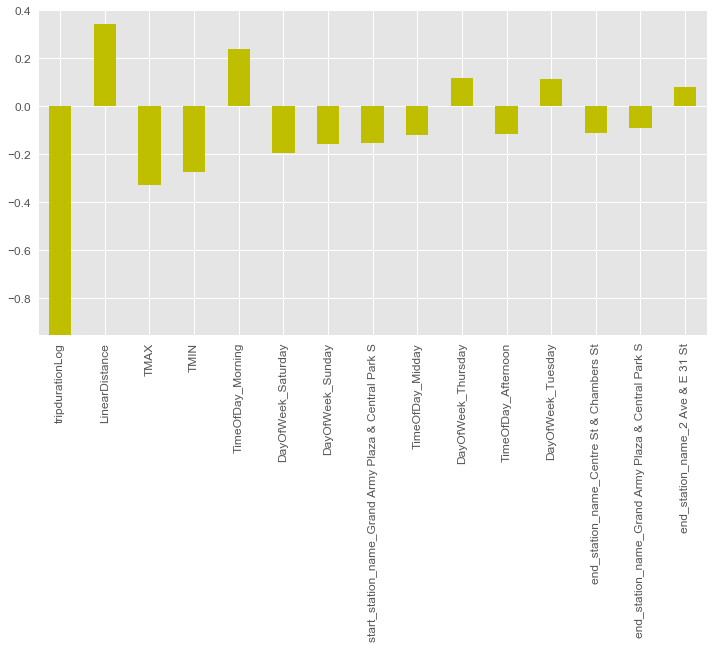

In [39]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

weights_top15 = abs(weights).sort_values(ascending = False).head(15)

weights_top15 = weights[weights_top15.index]

weights_top15.plot(kind = 'bar', figsize = (12, 6), color = 'y')

### Data Preparation

##### Define and prepare class variables
*XXXXXX Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. XXXXXX*

##### Describe the final dataset that is used for classification/regression
*XXXXXX (include a description of any newly formed variables you created) XXXXXX*

### Modeling and Evaluation

##### Choose and explain the evaluation metrics that will be used
*XXXXXX (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions. XXXXXX*

##### Choose the method used for dividing data into training and testing splits
*XXXXXX (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. XXXXXX*

##### Create three different classification/regression models for each task
*XXXXXX (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). XXXXXX*

*XXXXXX **Adjust parameters as appropriate to increase generalization performance using your chosen metric.*** *You must investigate different parameters of the algorithms! XXXXXX*

##### Analyze the results using a chosen method of evaluation
*XXXXXX **Use visualizations of the results to bolster the analysis.** Explain any visuals and analyze why they are interesting to someone that might use this model. XXXXXX*

##### Discuss the advantages of each model for each classification task
*XXXXXX If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course. XXXXXX*

##### Which attributes from the analysis are most important?
*XXXXXX Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task. XXXXXX*

### Deployment

##### How useful is the model for interested parties?
*XXXXXX (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? XXXXXX*

### Exceptional Work